#### This notebook demonstrates the use of a reweighing pre-processing algorithm for bias mitigation


In [ ]:
# load variables from computing environment
import dill
dill.load_session('nn_notebook_env.db')

In [41]:
# save variables to computing environment

import dill
dill.dump_session('nn_notebook_env.db')

In [1]:
%matplotlib inline
# Load all necessary packages
import sys
sys.path.insert(0, '/home/jl0274/AIF360')
import numpy as np
from tqdm import tqdm

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from IPython.display import Markdown, display
import matplotlib.pyplot as plt

from common_utils import compute_metrics

2024-12-02 13:52:03.167761: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 13:52:03.184051: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 13:52:03.189072: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 13:52:03.201454: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
pip install 'aif360[Reducti

In [2]:
import aif360
aif360.__file__

'/home/jl0274/AIF360/aif360/__init__.py'

In [3]:
import pandas as pd
X_train = pd.read_pickle('/home/jl0274/Senior Thesis/X_train_norm.pkl')
y_train = pd.read_pickle('/home/jl0274/Senior Thesis/y_train.pkl')
X_val = pd.read_pickle('/home/jl0274/Senior Thesis/X_val_norm.pkl')
y_val = pd.read_pickle('/home/jl0274/Senior Thesis/y_val.pkl')
X_test = pd.read_pickle('/home/jl0274/Senior Thesis/X_test_norm.pkl')
y_test = pd.read_pickle('/home/jl0274/Senior Thesis/y_test.pkl')
print(X_train.isna().any().any())
print(y_train.isna().any().any())
print(X_val.isna().any().any())
print(y_val.isna().any().any())
print(X_test.isna().any().any())
print(y_test.isna().any().any())

False
False
False
False
False
False


In [4]:
y_train.shape

(709199,)

#### Load dataset and set options

In [5]:
## import dataset
dataset_used = "adult" # "adult", "german", "compas"
protected_attribute_used = 1 # 1, 2


if dataset_used == "adult":
#     dataset_orig = AdultDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_adult(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_adult(['race'])
    
elif dataset_used == "german":
#     dataset_orig = GermanDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_german(['sex'])
    else:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
        dataset_orig = load_preproc_data_german(['age'])
    
elif dataset_used == "compas":
#     dataset_orig = CompasDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_compas(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_compas(['race'])

all_metrics =  ["Statistical parity difference",
                   "Average odds difference",
                   "Equal opportunity difference"]

#random seed for calibrated equal odds prediction
np.random.seed(1)

standard dataset: is na? False


#### Split into train, and test

In [6]:
# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

#### Clean up training data

In [7]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(827046, 21)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[array([0.])] [array([1.])]


#### Dataset feature names

['hoepa_status_2.0', 'hoepa_status_3.0', 'total_loan_costs', 'rate_spread', 'interest_rate', 'origination_charges', 'lender_credits', 'derived_dwelling_category_Single Family (1-4 Units):Site-Built', 'loan_term', 'discount_points', 'construction_method_2.0', 'tract_to_msa_income_percentage', 'combined_loan_to_value_ratio', 'tract_minority_population_percent', 'tract_population', 'property_value', 'tract_one_to_four_family_homes', 'tract_owner_occupied_units', 'purchaser_type_1.0', 'income', 'sex']


#### Metric for original training data

In [8]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.053096


#### Train with and transform the original training data

In [9]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

In [10]:
### Testing 
assert np.abs(dataset_transf_train.instance_weights.sum()-dataset_orig_train.instance_weights.sum())<1e-6

#### Metric with the transformed training data

In [11]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.000000


In [12]:
### Testing 
assert np.abs(metric_transf_train.mean_difference()) < 1e-6

### Train classifier on original data

In [16]:
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

# regression classifier and predictions
X_train = dataset_orig_train.features
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

params = {
    'units': 128,
    'layers': 2,
    'activation': 'tanh',
    'learning_rate': 0.0001,
    'batch': 32
}

optimizer = Adam(params['learning_rate'])

model = tf.keras.Sequential([
     tf.keras.layers.Dense(params['units'], activation=params['activation'], input_shape=(X_train.shape[1],)),
     tf.keras.layers.Dense(64, activation=params['activation']),
     tf.keras.layers.Dense(1)  # Output layer with 1 unit for regression
])

model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()
model.fit(X_train, y_train, epochs=50, batch_size=params['batch'], sample_weight=dataset_orig_train.instance_weights)

# Train the model
# xg_model.fit(X_train, y_train, 
#          sample_weight=dataset_orig_train.instance_weights)
y_train_pred = model.predict(X_train)

# positive class index
pos_ind = np.where(model.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

/home/jl0274/.conda/envs/gender-bias/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,137 (43.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


I0000 00:00:1733165625.571868  596571 service.cc:146] XLA service 0x7f7230008360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733165625.571915  596571 service.cc:154]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
I0000 00:00:1733165625.571918  596571 service.cc:154]   StreamExecutor device (1): Tesla V100-PCIE-32GB, Compute Capability 7.0
I0000 00:00:1733165625.571920  596571 service.cc:154]   StreamExecutor device (2): Tesla V100-PCIE-32GB, Compute Capability 7.0
2024-12-02 13:53:45.590355: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-02 13:53:45.654665: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90201


  199/25846 ━━━━━━━━━━━━━━━━━━━━ 19s 761us/step - loss: 0.3405

I0000 00:00:1733165626.042140  596571 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25846/25846 ━━━━━━━━━━━━━━━━━━━━ 20s 730us/step - loss: 0.0511
Epoch 2/50
25846/25846 ━━━━━━━━━━━━━━━━━━━━ 19s 719us/step - loss: 0.0394
Epoch 3/50
25846/25846 ━━━━━━━━━━━━━━━━━━━━ 19s 718us/step - loss: 0.0361
Epoch 4/50
25846/25846 ━━━━━━━━━━━━━━━━━━━━ 19s 720us/step - loss: 0.0331
Epoch 5/50
25846/25846 ━━━━━━━━━━━━━━━━━━━━ 19s 720us/step - loss: 0.0304
Epoch 6/50
25846/25846 ━━━━━━━━━━━━━━━━━━━━ 19s 718us/step - loss: 0.0282
Epoch 7/50
25846/25846 ━━━━━━━━━━━━━━━━━━━━ 19s 719us/step - loss: 0.0269
Epoch 8/50
25846/25846 ━━━━━━━━━━━━━━━━━━━━ 19s 719us/step - loss: 0.0256
Epoch 9/50
25846/25846 ━━━━━━━━━━━━━━━━━━━━ 19s 718us/step - loss: 0.0243
Epoch 10/50
25846/25846 ━━━━━━━━━━━━━━━━━━━━ 19s 719us/step - loss: 0.0237
Epoch 11/50
25846/25846 ━━━━━━━━━━━━━━━━━━━━ 19s 719us/step - loss: 0.0230
Epoch 12/50
25846/25846 ━━━━━━━━━━━━━━━━━━━━ 19s 719us/step - loss: 0.0227
Epoch 13/50
25846/25846 ━━━━━━━━━━━━━━━━━━━━ 19s 719us/step - loss: 0.0220
Epoch 14/50
25846/25846 ━━━━━━━━━━━━━━━━━━━━ 

AttributeError: 'Sequential' object has no attribute 'classes_'

#### Obtain scores for original validation and test sets

In [23]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = dataset_orig_valid_pred.features
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = model.predict(X_valid).reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = dataset_orig_test_pred.features
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = model.predict(X_test).reshape(-1,1)

5539/5539 ━━━━━━━━━━━━━━━━━━━━ 4s 640us/step
5539/5539 ━━━━━━━━━━━━━━━━━━━━ 3s 615us/step


In [ ]:
# scores is the estimated probabilities that each row is equal to 1, scores is an attribute of 
# the AdultDataset class - dataset_orig_test_pred is of AdultDataset type
dataset_orig_test_pred.scores

In [ ]:
X_test.shape

### Find the optimal classification threshold from the validation set

In [24]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.9852
Optimal classification threshold (no reweighing) = 0.4852


### Predictions from the original test set at the optimal classification threshold

In [25]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

Classification threshold used = 0.4852


 50%|█████     | 50/100 [00:03<00:03, 14.57it/s]

Balanced accuracy = 0.9847
Statistical parity difference = 0.0481
Disparate impact = 1.0687
Average odds difference = -0.0017
Equal opportunity difference = -0.0042
Theil index = 0.0224


100%|██████████| 100/100 [00:06<00:00, 14.48it/s]


In [26]:
metric_test_bef

OrderedDict([('Balanced accuracy', 0.9760022387526222),
             ('Statistical parity difference', 0.04688104453642039),
             ('Disparate impact', 1.0683063835952331),
             ('Average odds difference', -0.0021256531579563914),
             ('Equal opportunity difference', -0.004364663580224137),
             ('Theil index', 0.036763839176606986)])

#### Display results for all thresholds

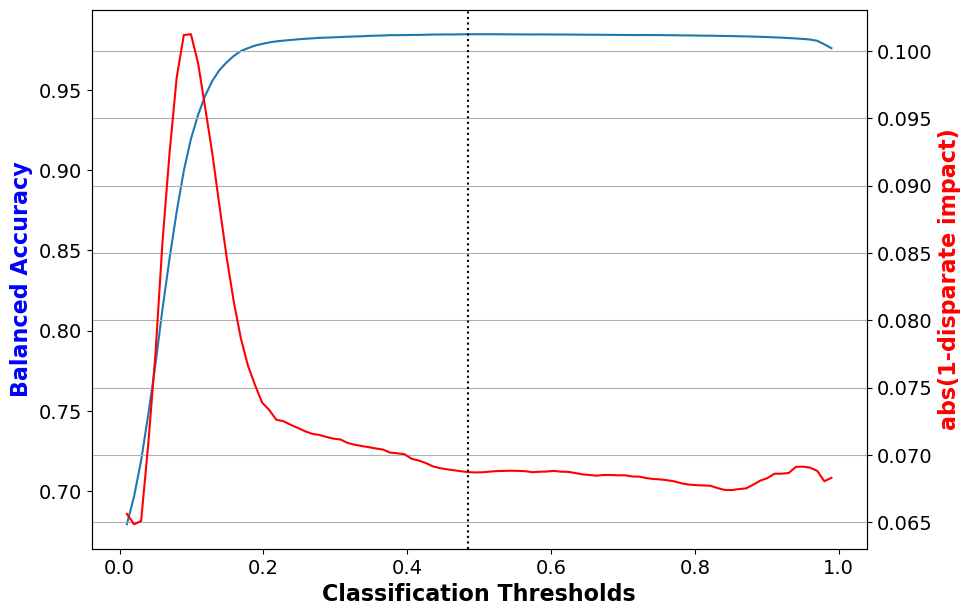

In [27]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.show()

```abs(1-disparate impact)``` must be small (close to 0) for classifier predictions to be fair.

However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

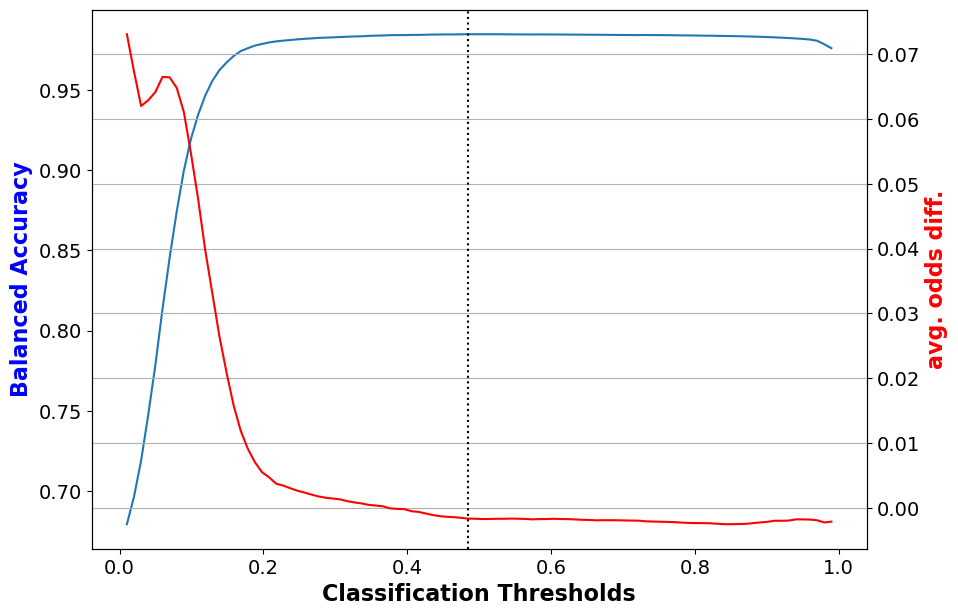

In [28]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.show()

```average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv))``` must be close to zero for the classifier to be fair.

However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

### Train classifier on transformed data

In [32]:
X_train = dataset_transf_train.features
y_train = dataset_transf_train.labels.ravel()

model = tf.keras.Sequential([
     tf.keras.layers.Dense(params['units'], activation=params['activation'], input_shape=(X_train.shape[1],)),
     tf.keras.layers.Dense(64, activation=params['activation']),
     tf.keras.layers.Dense(1)  # Output layer with 1 unit for regression
])
optimizer2 = Adam(params['learning_rate'])
model.compile(optimizer=optimizer2, loss='mean_squared_error')
model.summary()
model.fit(X_train, y_train, epochs=50, batch_size=params['batch'], sample_weight=dataset_orig_train.instance_weights)

y_train_pred = model.predict(X_train)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,137 (43.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
25846/25846 ━━━━━━━━━━━━━━━━━━━━ 20s 727us/step - loss: 0.0482
Epoch 2/50
25846/25846 ━━━━━━━━━━━━━━━━━━━━ 19s 723us/step - loss: 0.0390
Epoch 3/50
25846/25846 ━━━━━━━━━━━━━━━━━━━━ 19s 721us/step - loss: 0.0359
Epoch 4/50
25846/25846 ━━━━━━━━━━━━━━━━━━━━ 19s 723us/step - loss: 0.0328
Epoch 5/50
25846/25846 ━━━━━━━━━━━━━━━━━━━━ 19s 722us/step - loss: 0.0299
Epoch 6/50
25846/25846 ━━━━━━━━━━━━━━━━━━━━ 19s 722us/step - loss: 0.0275
Epoch 7/50
25846/25846 ━━━━━━━━━━━━━━━━━━━━ 19s 720us/step - loss: 0.0256
Epoch 8/50
25846/25846 ━━━━━━━━━━━━━━━━━━━━ 19s 721us/step - loss: 0.0246
Epoch 9/50
25846/25846 ━━━━━━━━━━━━━━━━━━━━ 19s 722us/step - loss: 0.0236
Epoch 10/50
25846/25846 ━━━━━━━━━━━━━━━━━━━━ 19s 720us/step - loss: 0.0228
Epoch 11/50
25846/25846 ━━━━━━━━━━━━━━━━━━━━ 19s 721us/step - loss: 0.0223
Epoch 12/50
25846/25846 ━━━━━━━━━━━━━━━━━━━━ 19s 721us/step - loss: 0.0219
Epoch 13/50
25846/25846 ━━━━━━━━━━━━━━━━━━━━ 19s 719us/step - loss: 0.0213
Epoch 14/50
25846/25846 ━━━━━━━━━━

#### Obtain scores for transformed test set

In [35]:
dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = dataset_transf_test_pred.features
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = model.predict(X_test).reshape(-1,1)

5539/5539 ━━━━━━━━━━━━━━━━━━━━ 3s 586us/step


### Predictions from the transformed test set at the optimal classification threshold

In [36]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

Classification threshold used = 0.4852


 50%|█████     | 50/100 [00:03<00:03, 14.28it/s]

Balanced accuracy = 0.9842
Statistical parity difference = 0.0494
Disparate impact = 1.0706
Average odds difference = 0.0000
Equal opportunity difference = -0.0032
Theil index = 0.0222


100%|██████████| 100/100 [00:06<00:00, 14.33it/s]


#### Display results for all thresholds

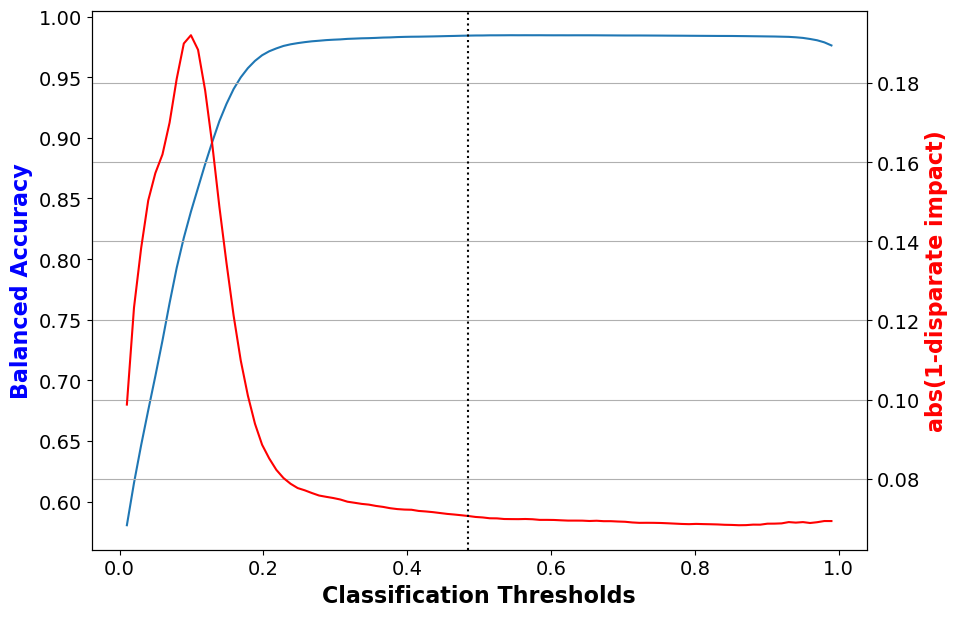

In [37]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.show()

```abs(1-disparate impact)``` must be small (close to 0) for classifier predictions to be fair.

For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case.
This implies fairness.

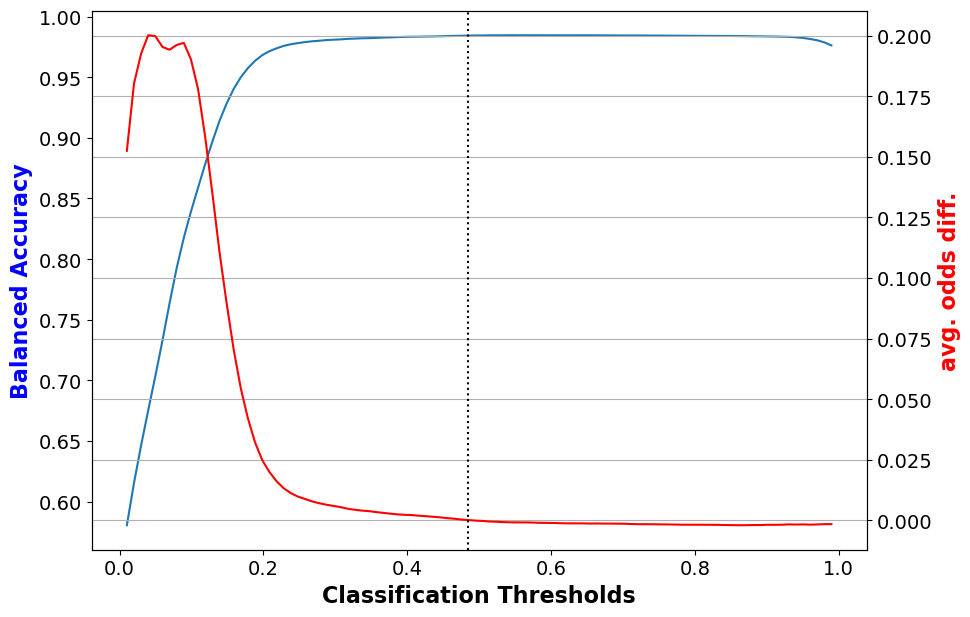

In [38]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.show()

```average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv))``` must be close to zero for the classifier to be fair.

For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case.
This implies fairness.

# Summary of Results
We show the optimal classification thresholds, and the fairness and accuracy metrics.

### Classification Threshold

0.4852

In [39]:
dis_table = f"""
### Fairness Metric: Disparate impact, Accuracy Metric: Balanced accuracy

#### Performance

|Sex (Acc-Bef)|Sex (Acc-Aft)|Sex (Fair-Bef)|Sex (Fair-Aft)|
|-|-|-|-|
|{round(metric_test_bef['Balanced accuracy'], 5)}|{round(metric_test_aft['Balanced accuracy'], 5)}|{round(metric_test_bef['Disparate impact'], 5)}|{round(metric_test_aft['Disparate impact'], 5)}|
"""

# Render the Markdown table
display(Markdown(dis_table))


### Fairness Metric: Disparate impact, Accuracy Metric: Balanced accuracy

#### Performance

|Sex (Acc-Bef)|Sex (Acc-Aft)|Sex (Fair-Bef)|Sex (Fair-Aft)|
|-|-|-|-|
|0.976|0.97616|1.06831|1.06933|


In [40]:
odds_table = f"""
### Fairness Metric: Average odds difference, Accuracy Metric: Balanced accuracy

#### Performance

|Sex (Acc-Bef)|Sex (Acc-Aft)|Sex (Fair-Bef)|Sex (Fair-Aft)|
|-|-|-|-|
|{round(metric_test_bef['Balanced accuracy'], 5)}|{round(metric_test_aft['Balanced accuracy'], 5)}|{round(metric_test_bef['Average odds difference'], 5)}|{round(metric_test_aft['Average odds difference'], 5)}|
"""

# Render the Markdown table
display(Markdown(odds_table))


### Fairness Metric: Average odds difference, Accuracy Metric: Balanced accuracy

#### Performance

|Sex (Acc-Bef)|Sex (Acc-Aft)|Sex (Fair-Bef)|Sex (Fair-Aft)|
|-|-|-|-|
|0.976|0.97616|-0.00213|-0.00166|
